# Задание 2

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px

import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import r2_score

import statsmodels.api as sm

# принудительно отключим предупреждения системы
import warnings
warnings.simplefilter(action = 'ignore', category = Warning)

import seaborn as sns

Импортируем файл с данными.
Превратим дату в индекс и сделаем ее объектом datetime.

In [ ]:
data = pd.read_csv('./training.csv', index_col = 'Date', parse_dates = True)
# data = data.rename(columns={'Value': 'value_train'})

test_data = pd.read_csv('./testing.csv', index_col = 'Date', parse_dates = True)
# test_data = test_data.rename(columns={'Value': 'value_test'})

all_data = pd.concat([data, test_data])
all_data.head()

,Value
Date,
1959-01-01,22.8331
1959-02-01,23.2802
1959-03-01,23.6156
1959-04-01,24.1186
1959-05-01,24.4820


Посмотрим, как выглядят наши данные.

Отобразим все имеющиеся данные

<Axes: xlabel='Date'>

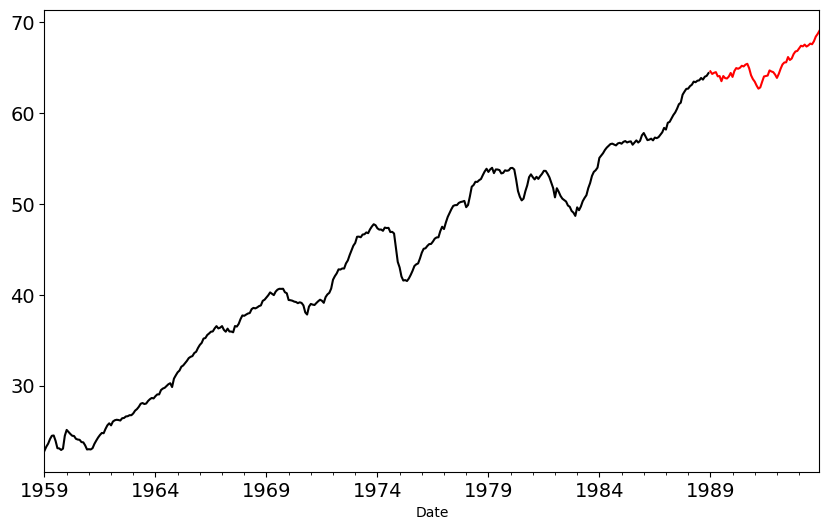

In [ ]:
data.Value.plot( figsize=(10,6), fontsize=14, color = 'black')
test_data.Value.plot( figsize=(10,6), fontsize=14, color = 'red')

## Проведем проверку данных на стационарность
- графически
- тест Дики-Фуллера

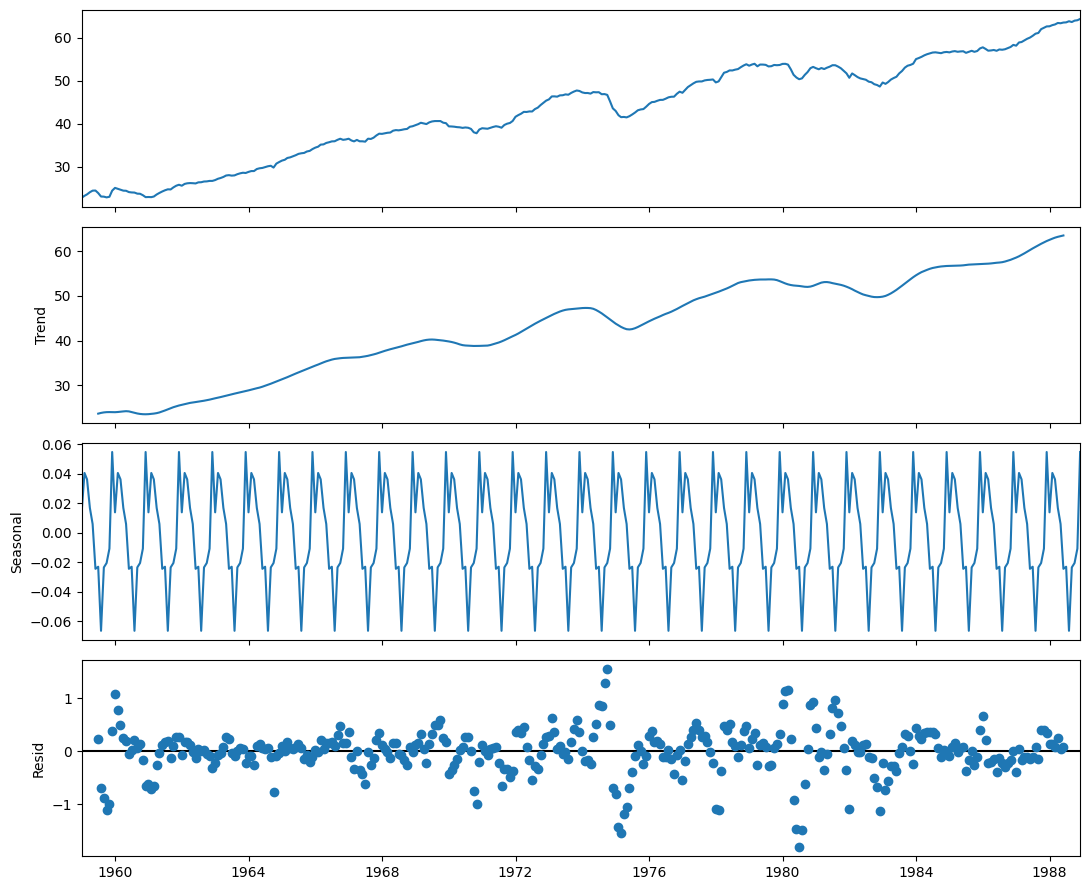

In [ ]:
# импортируем функцию seasonal_decompose из statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

# задаем размер графика
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

# применяем функцию к данным о перевозках
decompose = seasonal_decompose(data)
decompose.plot()

plt.show()

Стационарность временного ряда говрит о том, что отсутствуют такие компоненты как тренд и сезонность. То есть среднее значение и дисперсия не меняются со смещением во времени.

По нашим данным видно, что присутствует определенный тренд и сезоннсоть. Но тем не менее видно, что присутствуют некоторые циклические колебания.

### Проведем тест Дики-Фуллера (Dickey-Fuller test)

H 0 : Временной ряд является нестационарным. Другими словами, он имеет некоторую структуру, зависящую от времени, и не имеет постоянной дисперсии во времени.

H 1 : временной ряд является стационарным.

Если p-значение из теста меньше некоторого уровня значимости (например, α = 0,05), то мы можем отвергнуть нулевую гипотезу и сделать вывод, что временной ряд является стационарным.

In [ ]:
# импортируем необходимую функцию
from statsmodels.tsa.stattools import adfuller

def DF_test(data):
    # передадим ей столбец с данными о перевозках и поместим результат в adf_test
    adf_test = adfuller(data['Value'])
    p_value = adf_test[1]

    # выведем p-value
    print(f'p-value = {p_value:.{2}%}')

    if p_value < 0.05:
        print('Отвергаем гипотезу H0, сл ВР стационарный')

    return p_value

p_value = DF_test(data)

p-value = 93.19%


В нашем случае p-значение > 5% следовательно мы моджем отвергнуть гипотезу H1. Наш ряд является нестационарным.

# Проверить является ли временной ряд интегрированным порядка

Интегрированный временной ряд — нестационарный временной ряд, разности некоторого порядка от которого являются стационарным временным рядом.
Подберем коэффициент K.

In [ ]:
def find_integration_order(data):
    p_value = 1
    k = 1

    while p_value > 0.05:
        result = adfuller(data.diff().dropna())  # применяем разность порядка 1
        p_value = result[1]

        if p_value > 0.05:
            k += 1
            data = data.diff().dropna()

    print(f"The time series is integrated of order {k}")
    return k


In [ ]:
# your_time_series - ваш временной ряд
# k = find_integration_order(data)
data_training_diff = data.Value.diff(periods=1).dropna()
type(data_training_diff)

pandas.core.series.Series

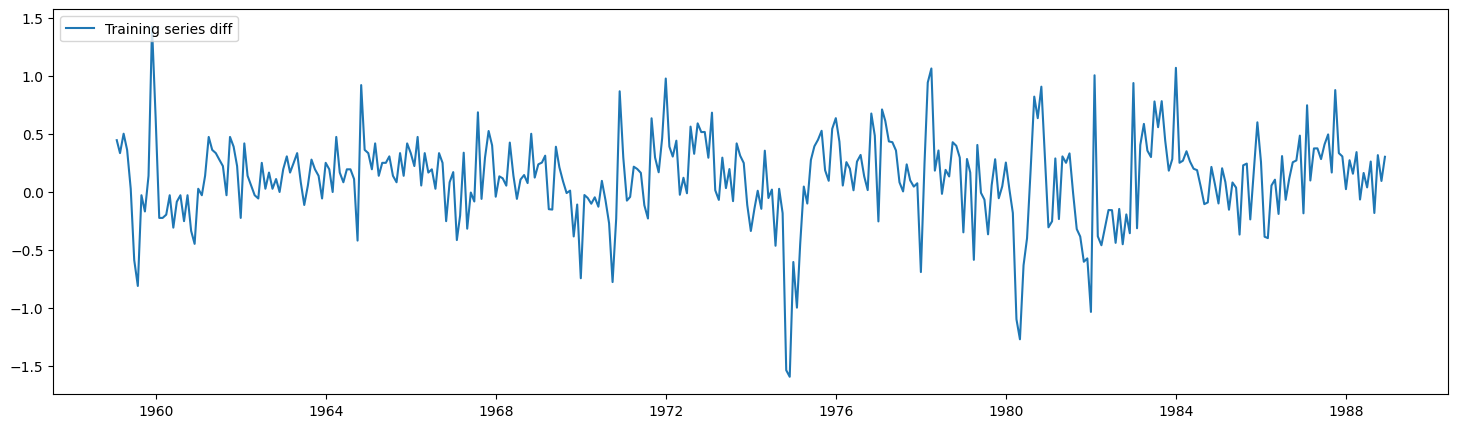

In [ ]:
plt.figure(figsize=(18,5))
plt.plot(data_training_diff, label='Training series diff')
plt.legend(loc='upper left')
plt.show()

Мы выяснили, что наш ВР является интегрированным порядка K = 1.

In [ ]:
otg1diff = data.diff(periods=1).dropna()
p = DF_test(otg1diff)
print(f'{p:.{2}%}')

p-value = 0.00%
Отвергаем гипотезу H0, сл ВР стационарный
0.00%


## Модель ARIMA
Применим к ВР модель ARIMA, подобрав необходимые параметры с помощью функции
автокорреляции и функции частичной автокорреляции

Модель ARIMA (Autoregressive Integrated Moving Average) часто используется для прогнозирования временных рядов. Она состоит из трех основных компонентов: авторегрессии (AR), разности (I) и скользящего среднего (MA).

Для применения модели ARIMA к временному ряду необходимо определить параметры p, d и q, которые соответствуют компонентам AR, I и MA соответственно.

1. Параметр d - это количество разностей, необходимое для стабилизации временного ряда. Он обычно подбирается путем пошагового применения разностей к исходному ряду до тех пор, пока ряд не станет стационарным.

2. Параметры p и q можно определить с помощью функций автокорреляции (ACF) и функции частичной автокорреляции (PACF). Функция ACF показывает корреляцию между временным рядом и его лагом (отстающим значением), а функция PACF отображает корреляцию между временным рядом и его отстающими значениями с учетом промежуточных лагов.

Параметр p обычно выбирается из PACF, где мы ищем последний значимый лаг. Параметр q выбирается из ACF, где мы также ищем последний значимый лаг.

Выбор параметров обоснован тем, что они помогают модели ARIMA учитывать автокорреляцию в данных и подбираются на основе статистических тестов значимости корреляции. После выбора параметров модель ARIMA может быть использована для прогнозирования будущих значений временного ряда.

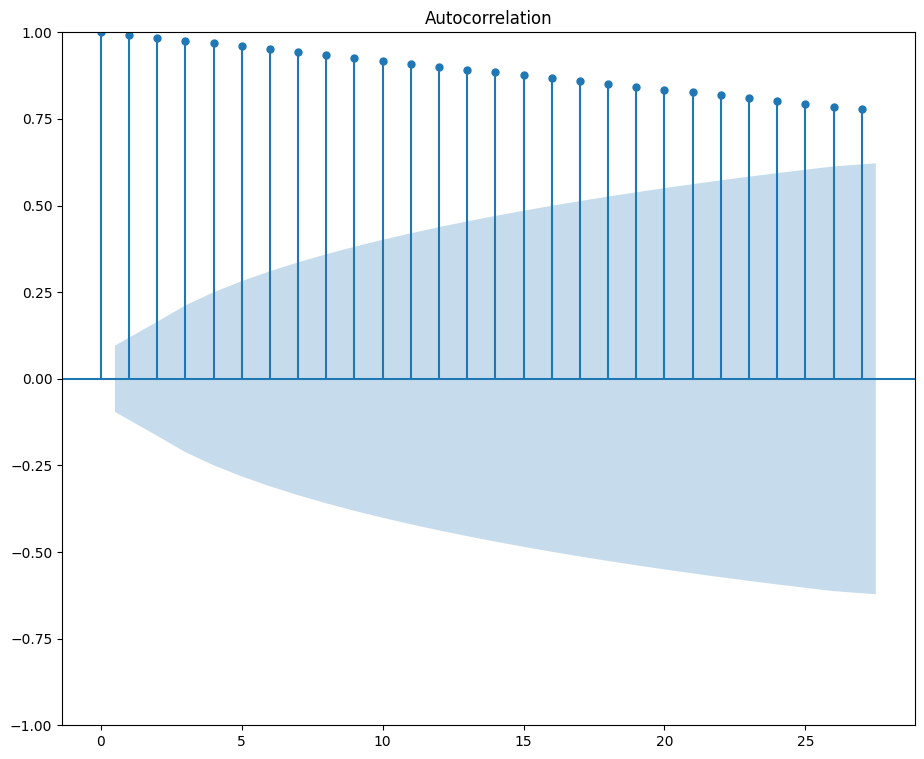

In [ ]:
plot_acf(all_data.Value)
plt.show()

## Подбор параметров ARIMA
### Подбор параметра d



In [ ]:
d = 1

### Подбор параметров p и q на основе ACF и PACF

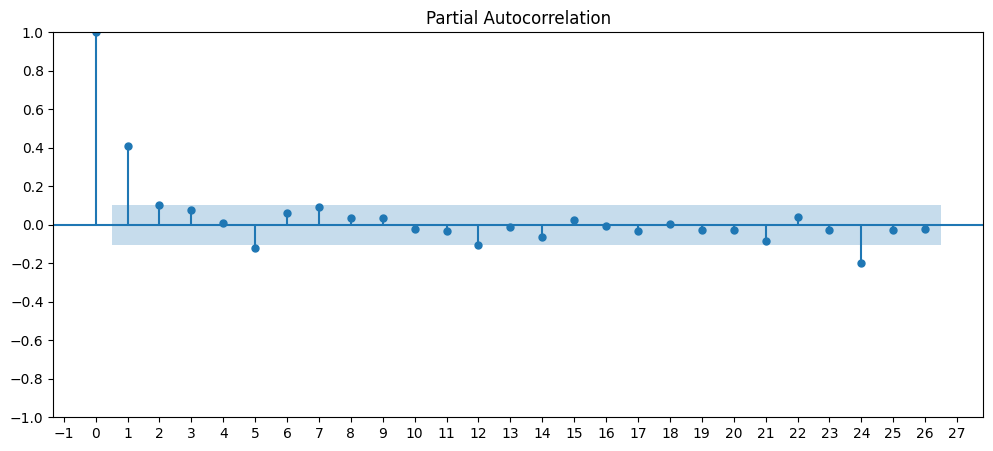

In [ ]:
# Определение p по PACF
fig, ax = plt.subplots(figsize=(12, 5))
plt.locator_params (axis='x', nbins= 30)
plt.locator_params (axis='y', nbins= 10)
plot_pacf(data_training_diff, ax=ax)
plt.show()

 - Мы видим, что 1-е запаздывание является наиболее значительным. Таким образом, мы считаем, что p равно 1.

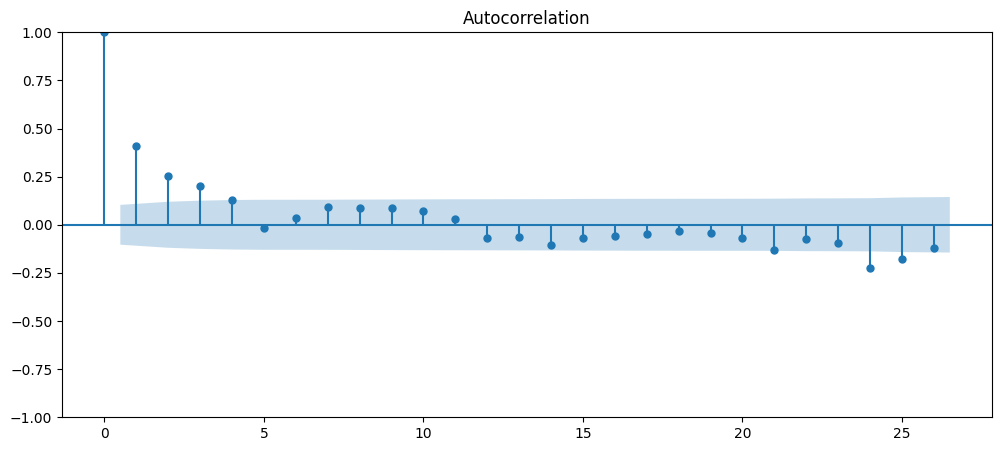

In [ ]:
# Определение q по ACF
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(data_training_diff, ax=ax)
plt.show()

- По графику ACF видно, что поседний значимый лаг достинается при q = 4

### Модель номер 1

In [ ]:
# Финальный подбор ARIMA
p = 1  # значение p выбрано на основе PACF
q = 4  # значение q выбрано на основе ACF
d = 1

start = len(data)
end = len(data) + len(test_data) - 1

model = ARIMA(data, order=(p, d, q), seasonal_order = (p, d, q, 28))
model_fit = model.fit()

# Вывод результатов
predictions = model_fit.predict(start, end)

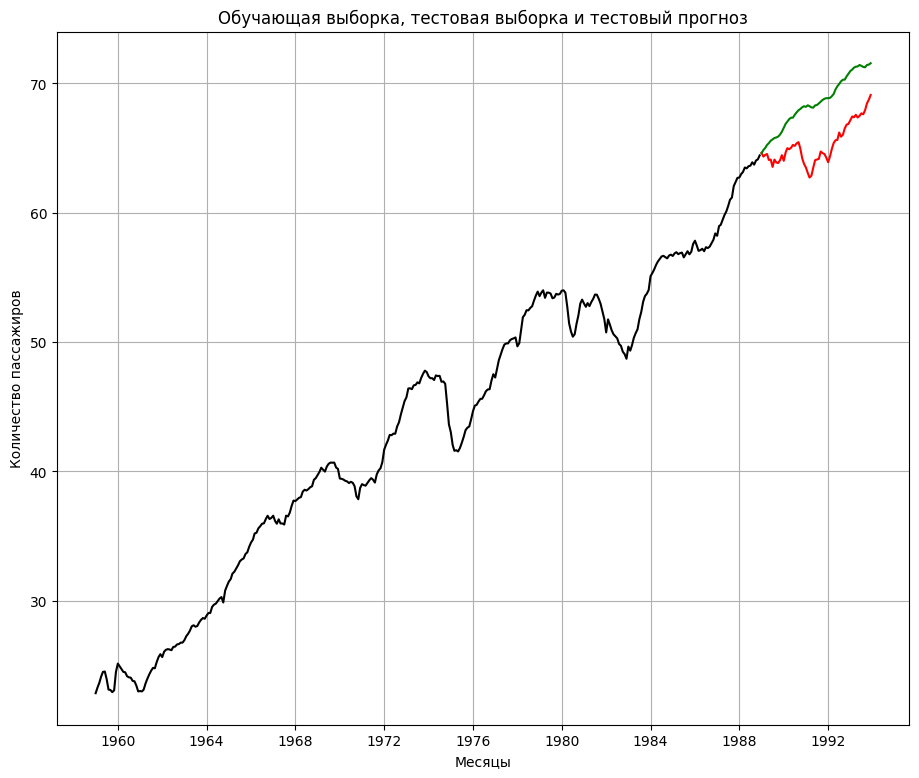

In [ ]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.plot(data, color = "black")
plt.plot(test_data, color = "red")
plt.plot(predictions, color = "green")

# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка и тестовый прогноз")
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')

# добавим сетку
plt.grid()

plt.show()

In [ ]:
r2_score(test_data, predictions)

-3.9909413719288587

### Модель номер 2

In [ ]:
p = 12  # значение p выбрано на основе PACF
d = 1
q = 4  # значение q выбрано на основе ACF

model = ARIMA(data, order=(p, d, q))
model_fit = model.fit()

# Вывод результатов
predictions = model_fit.predict(start, end)

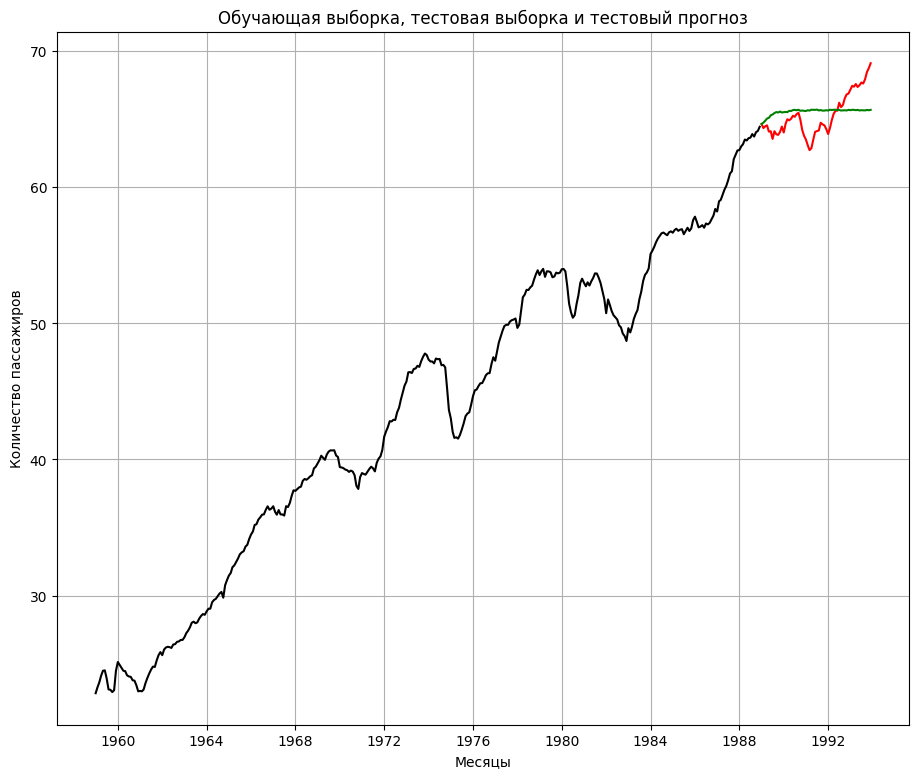

In [ ]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.plot(data, color = "black")
plt.plot(test_data, color = "red")
plt.plot(predictions, color = "green")

# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка и тестовый прогноз")
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')

# добавим сетку
plt.grid()

plt.show()

In [ ]:
r2_score(test_data, predictions)

0.024616415711979478

### Модель номер 3

In [ ]:
p = 12  # значение p выбрано на основе PACF
d = 1
q = 40  # значение q выбрано на основе ACF

model = ARIMA(data, order=(p, d, q))
model_fit = model.fit()

# Вывод результатов
predictions = model_fit.predict(start, end)

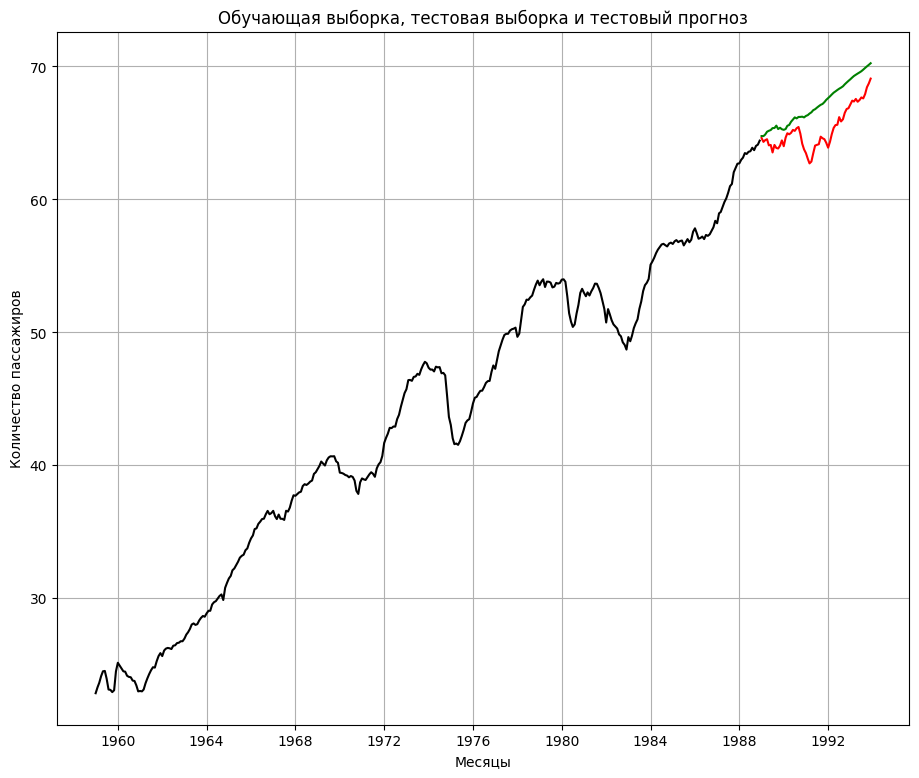

In [ ]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.plot(data, color = "black")
plt.plot(test_data, color = "red")
plt.plot(predictions, color = "green")

# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка и тестовый прогноз")
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')

# добавим сетку
plt.grid()

plt.show()

<Axes: xlabel='Date', ylabel='predicted_mean'>

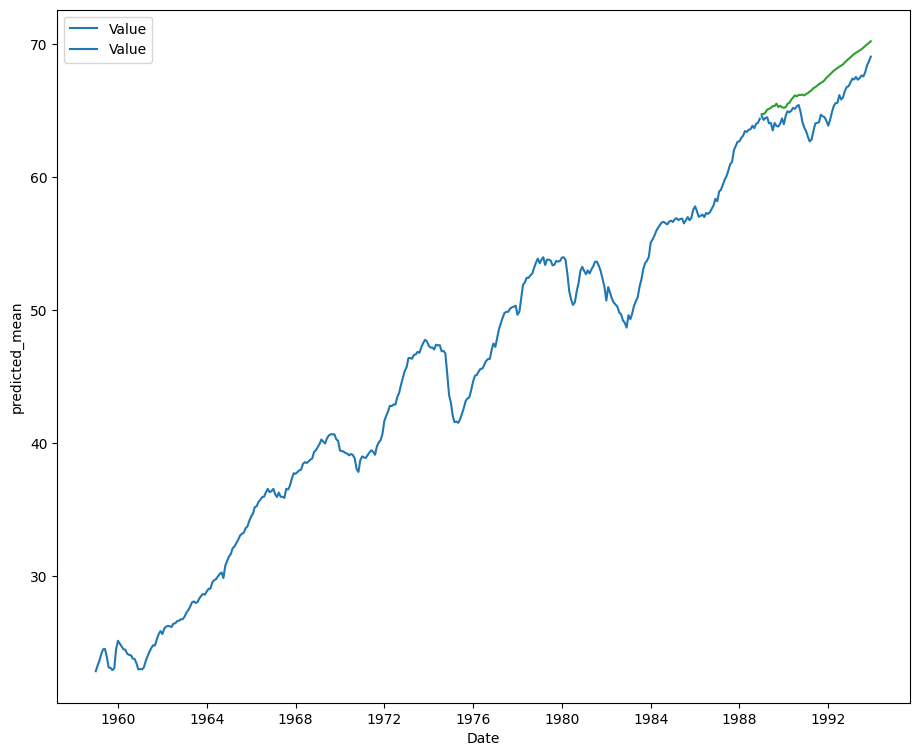

In [ ]:
# sns.lineplot(data)
sns.lineplot(data)
sns.lineplot(test_data)
sns.lineplot(predictions)

In [ ]:
r2_score(test_data, predictions)

-0.8592513791034966